In [1]:
# Import basic functionality
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
import re
import os
# Import the required library
!pip install geopy
from geopy.geocoders import Nominatim

In [2]:
# Read the data
sentencing_cleaned = pd.read_csv("/Users/leowu/Desktop/Study_Materials/Data_Science1/pset2_inputdata/sentencing_cleaned.csv")

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_1635/3105782160.py:2: DtypeWarning: Columns (10,11,16,25) have mixed types. Specify dtype option on import or set low_memory=False.


In [3]:
# Get the head of the data
sentencing_cleaned.head()

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,simplified_offense_derived,is_black_derived,is_hisp_derived,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,Homicide,True,False,False,False,True,27.0,2014-10-16,2014-10-01,judge_40
1,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,Homicide,True,False,False,False,True,30.0,2014-08-06,2014-08-01,judge_310
2,154954734978,225758446387,6/8/2001 12:00:00 AM,PROMIS Conversion,True,54885211141,174293345821,VIO BAIL BOND/CLASS 1,1,12/2/2013 12:00:00 AM,...,PROMIS Conversion,False,True,False,False,True,38.0,2013-12-02,2013-12-01,judge_162
3,155222744754,217349881776,1/31/2001 12:00:00 AM,PROMIS Conversion,True,53899906462,280120721775,POSS AMT CON SUB EXCEPT (A)/(D),1,9/10/2012 12:00:00 AM,...,Narcotics,True,False,False,False,False,33.0,2012-09-10,2012-09-01,judge_331
4,155327892699,217212381455,2/6/2001 12:00:00 AM,PROMIS Conversion,True,53938518259,164877860811,DUI LIC SUSPENDED OR REVOKED (EFFECTIVE 4-13-2...,1,9/19/2014 12:00:00 AM,...,PROMIS Conversion,False,False,True,False,True,49.0,2014-09-19,2014-09-01,judge_314


In [4]:
# Get the head of the data
sentencing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135165 entries, 0 to 135164
Data columns (total 52 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   CASE_ID                            135165 non-null  int64  
 1   CASE_PARTICIPANT_ID                135165 non-null  int64  
 2   RECEIVED_DATE                      135165 non-null  object 
 3   OFFENSE_CATEGORY                   135165 non-null  object 
 4   PRIMARY_CHARGE_FLAG                135165 non-null  bool   
 5   CHARGE_ID                          135165 non-null  int64  
 6   CHARGE_VERSION_ID                  135165 non-null  int64  
 7   DISPOSITION_CHARGED_OFFENSE_TITLE  135165 non-null  object 
 8   CHARGE_COUNT                       135165 non-null  int64  
 9   DISPOSITION_DATE                   135165 non-null  object 
 10  DISPOSITION_CHARGED_CHAPTER        135165 non-null  object 
 11  DISPOSITION_CHARGED_ACT            1342

In [5]:
# Group by year and month, and get relevant variables 
sentencing = sentencing_cleaned.groupby('sentenceym_derived').agg(unique_cases = ('CASE_ID', lambda x : len(x.unique())), 
                                                                  Black = ('is_black_derived', 'sum'),
                                                                  White = ('is_white_derived', 'sum')).reset_index()
sentencing = sentencing.melt(id_vars = ['sentenceym_derived', 'unique_cases'], var_name = 'race', value_name = 'defendants_num')
sentencing['fraction'] = sentencing.defendants_num / sentencing.unique_cases
sentencing

,sentenceym_derived,unique_cases,race,defendants_num,fraction
0,2012-01-01,1674,Black,1134,0.677419
1,2012-02-01,1450,Black,941,0.648966
2,2012-03-01,1612,Black,1030,0.638958
3,2012-04-01,1436,Black,1000,0.696379
4,2012-05-01,1545,Black,1074,0.695146
...,...,...,...,...,...
217,2020-11-01,491,White,76,0.154786
218,2020-12-01,537,White,85,0.158287
219,2021-01-01,447,White,50,0.111857
220,2021-02-01,491,White,66,0.134420


In [16]:
# Investigating the first type of disparity by COMMITMENT_TYPE == "Illinois Department of Corrections"
sentencing_cleaned['Incarcerated_black'] = np.where((sentencing_cleaned.COMMITMENT_TYPE == 'Illinois Department of Corrections') & (sentencing_cleaned.is_black_derived == True), True, False)
sentencing_cleaned['Incarcerated_white'] = np.where((sentencing_cleaned.COMMITMENT_TYPE == 'Illinois Department of Corrections') & (sentencing_cleaned.is_white_derived == True), True, False)
sentencing_incarceration = sentencing_cleaned.groupby('sentenceym_derived').agg(Black_derived = ('is_black_derived', 'sum'),
                                                                                White_derived = ('is_white_derived', 'sum'),
                                                                                Black_incarcerated =('Incarcerated_black','sum'),
                                                                                White_incarcerated =('Incarcerated_white','sum')).reset_index()
sentencing_incarceration['Difference']= (sentencing_incarceration['Black_incarcerated']/ sentencing_incarceration['Black_derived']) - (sentencing_incarceration['White_incarcerated']/ sentencing_incarceration['White_derived']) 
sentencing_incarceration

,sentenceym_derived,Black_derived,White_derived,Black_incarcerated,White_incarcerated,Difference
0,2012-01-01,1134,242,674,87,0.234852
1,2012-02-01,941,233,566,87,0.228097
2,2012-03-01,1030,255,602,113,0.141329
3,2012-04-01,1000,211,598,94,0.152502
4,2012-05-01,1074,223,579,73,0.211752
...,...,...,...,...,...,...
106,2020-11-01,298,76,122,23,0.106764
107,2020-12-01,347,85,170,32,0.113443
108,2021-01-01,278,50,138,22,0.056403
109,2021-02-01,320,66,136,13,0.228030


/Users/leowu/opt/anaconda3/lib/python3.9/site-packages/plotnine/stats/smoothers.py:309: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.


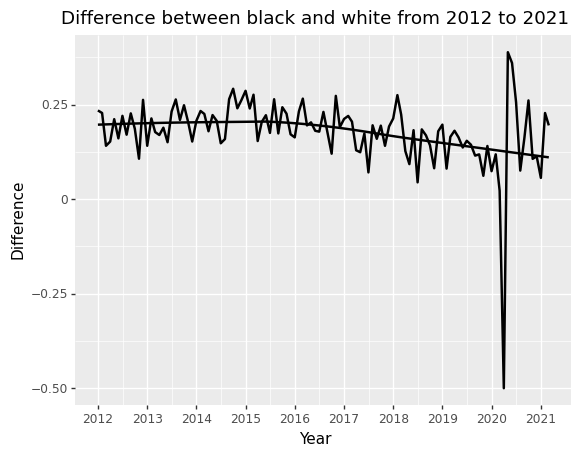

<ggplot: (8763503323173)>

In [24]:
ggplot(sentencing_incarceration,aes(x= 'sentenceym_derived' , y= 'Difference',group=1)) + geom_line(size=1) + geom_smooth() + scale_x_date(date_labels = "%Y")+ labs(x = "Year",y = "Difference", title = "Difference between black and white from 2012 to 2021") 

In [25]:
# Group by simplified_offense_derived
sentencing_offenses = sentencing_cleaned.groupby('simplified_offense_derived').agg(Black_derived = ('is_black_derived', 'sum'),
                                                                                   White_derived = ('is_white_derived', 'sum'),
                                                                                   Black_incarcerated =('Incarcerated_black','sum'),
                                                                                   White_incarcerated =('Incarcerated_white','sum')).reset_index()                                           
sentencing_offenses 

,simplified_offense_derived,Black_derived,White_derived,Black_incarcerated,White_incarcerated
0,Armed Robbery,1719,161,1633,148
1,Armed Violence,1,0,1,0
2,Arson,131,58,88,30
3,Assault Police Officer,130,41,79,12
4,Attempt Armed Robbery,181,27,149,19
...,...,...,...,...,...
59,Unlawful Restraint,20,18,10,5
60,Vehicle-related,2400,362,1329,212
61,Violate Bail Bond,26,11,21,8
62,Violation Order Of Protection,130,73,99,41


In [26]:
## your code here that reads in data and filters the rows
sentence_filter = sentencing_cleaned[(sentencing_cleaned.COMMITMENT_TYPE == 'Illinois Department of Corrections') 
                                     & ((sentencing_cleaned.is_white_derived == True)| (sentencing_cleaned.is_black_derived == True)) 
                                     & (~sentencing_cleaned.COMMITMENT_UNIT.isin(['Term','Pounds','Dollars']))]
sentence_filter

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_hisp_derived,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived,Incarcerated_black,Incarcerated_white
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,False,False,False,True,27.0,2014-10-16,2014-10-01,judge_40,True,False
1,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,False,False,False,True,30.0,2014-08-06,2014-08-01,judge_310,True,False
5,155685924389,221749325828,6/15/2001 12:00:00 AM,PROMIS Conversion,True,55017536987,687589180737,AGGRAVATED CRIMINAL SEXUAL ASSAULT,1,5/3/2013 12:00:00 AM,...,False,False,False,True,NaN,2013-05-03,2013-05-01,judge_287,True,False
7,156558681704,231553844285,7/17/2001 12:00:00 AM,PROMIS Conversion,True,58235136444,720561595284,2ND DEGREE MURDER,1,12/4/2014 12:00:00 AM,...,False,False,False,True,17.0,2014-12-04,2014-12-01,judge_329,True,False
9,156996749190,238415836990,10/20/2001 12:00:00 AM,PROMIS Conversion,True,58424726399,219609793234,MURDER/INTENT TO KILL/INJURE,1,3/14/2012 12:00:00 AM,...,False,False,False,True,23.0,2012-03-14,2012-03-01,judge_113,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135117,444576672584,902195288394,11/19/2020 12:00:00 AM,Driving With Suspended Or Revoked License,True,446042822953,832902252993,"FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT,...",1,3/16/2021 12:00:00 AM,...,False,False,False,True,45.0,2021-02-19,2021-02-01,judge_287,True,False
135128,444757010121,902797855005,12/4/2020 12:00:00 AM,Credit Card Cases,True,446970360764,834641370221,IDENTITY THEFT,1,3/2/2021 12:00:00 AM,...,False,True,False,True,44.0,2021-02-17,2021-02-01,judge_90,False,True
135143,444982872606,903587656097,9/19/2014 12:00:00 AM,Forgery,True,446915459615,834537766815,FORGERY,1,3/19/2021 12:00:00 AM,...,False,False,False,True,33.0,2021-03-03,2021-03-01,judge_287,True,False
135151,445140741379,904087923223,1/7/2021 12:00:00 AM,Possession of Stolen Motor Vehicle,True,447180111306,837593366637,ATTEMPT POSSESSION OF A STOLEN MOTOR VEHICLE,1,3/2/2021 12:00:00 AM,...,False,False,False,True,24.0,2021-03-02,2021-03-01,judge_4,True,False


In [27]:
## Your code here on translation of units(method 1)
def transition(df: pd.DataFrame):
    df['senlength_derived'] = [float(u)
      if v == 'Days'
      else float(float(u) / 24) 
           if v == 'Hours'
           else float(float(u)* 365) 
                if v == 'Year(s)'
                else float(float(u)* 30.5) 
                    if v == 'Months'
                    else float(float(u) * 7) 
                        if v == 'Weeks'
                        else float((100-20)* 365)
                               if (v == 'Natural Life') & (np.isnan(i))
                               else float((100-float(i))* 365) 
      for u,v,i in zip(df.COMMITMENT_TERM,df.COMMITMENT_UNIT,df.age_derived)]
    
    return df

In [28]:
transition(df = sentence_filter)

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_2425/3574255785.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived,Incarcerated_black,Incarcerated_white,senlength_derived
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,False,False,True,27.0,2014-10-16,2014-10-01,judge_40,True,False,22630.0
1,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,False,False,True,30.0,2014-08-06,2014-08-01,judge_310,True,False,25550.0
5,155685924389,221749325828,6/15/2001 12:00:00 AM,PROMIS Conversion,True,55017536987,687589180737,AGGRAVATED CRIMINAL SEXUAL ASSAULT,1,5/3/2013 12:00:00 AM,...,False,False,True,NaN,2013-05-03,2013-05-01,judge_287,True,False,3650.0
7,156558681704,231553844285,7/17/2001 12:00:00 AM,PROMIS Conversion,True,58235136444,720561595284,2ND DEGREE MURDER,1,12/4/2014 12:00:00 AM,...,False,False,True,17.0,2014-12-04,2014-12-01,judge_329,True,False,7300.0
9,156996749190,238415836990,10/20/2001 12:00:00 AM,PROMIS Conversion,True,58424726399,219609793234,MURDER/INTENT TO KILL/INJURE,1,3/14/2012 12:00:00 AM,...,False,False,True,23.0,2012-03-14,2012-03-01,judge_113,True,False,16425.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135117,444576672584,902195288394,11/19/2020 12:00:00 AM,Driving With Suspended Or Revoked License,True,446042822953,832902252993,"FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT,...",1,3/16/2021 12:00:00 AM,...,False,False,True,45.0,2021-02-19,2021-02-01,judge_287,True,False,549.0
135128,444757010121,902797855005,12/4/2020 12:00:00 AM,Credit Card Cases,True,446970360764,834641370221,IDENTITY THEFT,1,3/2/2021 12:00:00 AM,...,True,False,True,44.0,2021-02-17,2021-02-01,judge_90,False,True,1825.0
135143,444982872606,903587656097,9/19/2014 12:00:00 AM,Forgery,True,446915459615,834537766815,FORGERY,1,3/19/2021 12:00:00 AM,...,False,False,True,33.0,2021-03-03,2021-03-01,judge_287,True,False,730.0
135151,445140741379,904087923223,1/7/2021 12:00:00 AM,Possession of Stolen Motor Vehicle,True,447180111306,837593366637,ATTEMPT POSSESSION OF A STOLEN MOTOR VEHICLE,1,3/2/2021 12:00:00 AM,...,False,False,True,24.0,2021-03-02,2021-03-01,judge_4,True,False,730.0


# Group by SENTENCE_COURT_NAME

1. Remove the NA value or PROMIS value in SENTENCE_COURT_NAME, and calculate each number.

In [154]:
sentence_court = sentencing_cleaned.drop(sentencing_cleaned[(sentencing_cleaned.SENTENCE_COURT_NAME.isna())|\
                                                            (sentencing_cleaned.SENTENCE_COURT_NAME == 'PROMIS')].index)

In [155]:
sentence_court_num = sentence_court.groupby('SENTENCE_COURT_NAME').agg(Number = ('CASE_PARTICIPANT_ID', 'count')).reset_index()

In [156]:
sentence_court_num['District'] = [i.split('-')[0] for i in sentence_court_num.SENTENCE_COURT_NAME]
sentence_court_num['City'] = [i.split('-')[1] for i in sentence_court_num.SENTENCE_COURT_NAME]

In [157]:
sentence_court_num 

,SENTENCE_COURT_NAME,Number,District,City
0,District 1 - Chicago,74297,District 1,Chicago
1,District 2 - Skokie,16264,District 2,Skokie
2,District 3 - Rolling Meadows,8971,District 3,Rolling Meadows
3,District 4 - Maywood,10584,District 4,Maywood
4,District 5 - Bridgeview,13946,District 5,Bridgeview
5,District 6 - Markham,10862,District 6,Markham


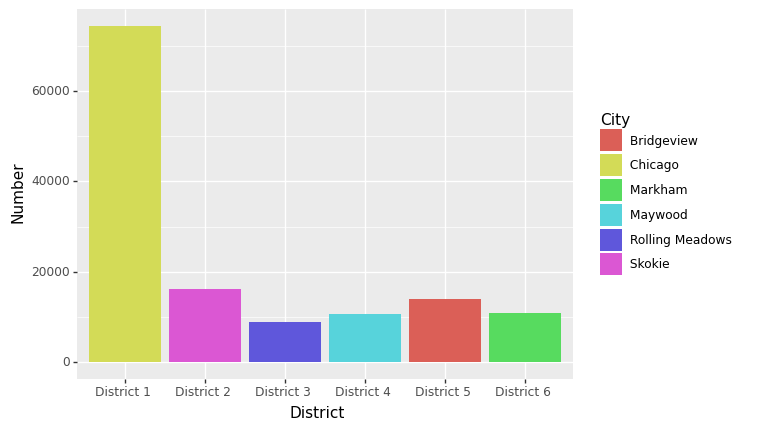

<ggplot: (8763530292194)>

In [158]:
ggplot(sentence_court_num, aes(x='District', y='Number', fill = 'City')) +\
geom_bar(stat = 'identity',position = position_dodge())

In [159]:
sentence_court1 = sentence_court.drop(sentence_court[(sentence_court.SENTENCE_COURT_FACILITY.isna())|\
                                                    (sentence_court.SENTENCE_COURT_FACILITY == 'PROMIS')].index)

In [161]:
sentence_court2 = sentence_court1.groupby(['SENTENCE_COURT_NAME','SENTENCE_COURT_FACILITY']).\
agg(Number = ('CASE_PARTICIPANT_ID', 'count')).reset_index()

In [162]:
sentence_court2['City'] = [i.split('-')[1] for i in sentence_court2.SENTENCE_COURT_NAME]
replace = '\(([^)]+)\)'
sentence_court2['SENTENCE_COURT_FACILITY'] = [re.sub(replace,'',i) for i in sentence_court2['SENTENCE_COURT_FACILITY']]
sentence_court2['Address'] = [i + ' ' + j if j == ' Chicago' else i 
                              for i,j in zip(sentence_court2.SENTENCE_COURT_FACILITY,sentence_court2.City)]

In [163]:
sentence_court2

,SENTENCE_COURT_NAME,SENTENCE_COURT_FACILITY,Number,City,Address
0,District 1 - Chicago,26TH Street,73448,Chicago,26TH Street Chicago
1,District 1 - Chicago,51st & Wentworth,17,Chicago,51st & Wentworth Chicago
2,District 1 - Chicago,727 E. 111th Street,11,Chicago,727 E. 111th Street Chicago
3,District 1 - Chicago,Belmont & Western,255,Chicago,Belmont & Western Chicago
4,District 1 - Chicago,DNU_3605 W. Fillmore St,1,Chicago,DNU_3605 W. Fillmore St Chicago
5,District 1 - Chicago,DV Courthouse,78,Chicago,DV Courthouse Chicago
6,District 1 - Chicago,Daley Center,1,Chicago,Daley Center Chicago
7,District 1 - Chicago,Grand & Central,58,Chicago,Grand & Central Chicago
8,District 1 - Chicago,Harrison & Kedzie,81,Chicago,Harrison & Kedzie Chicago
9,District 2 - Skokie,Skokie Courthouse,16219,Skokie,Skokie Courthouse


In [164]:
location = [x for x in sentence_court2['Address'].tolist() 
            if type(x) == str]
latitude = []
longitude = []
for i in range(0,len(location)):
    try:
        address = location[i]
        geolocator = Nominatim(user_agent="MyApp")
        loc = geolocator.geocode(address)
        latitude.append(loc.latitude)
        longitude.append(loc.longitude)
    except:
        latitude.append(np.nan)
        longitude.append(np.nan)
    

sentence_court2['latitude'] = latitude
sentence_court2['longitude'] = longitude

In [165]:
sentence_court2

,SENTENCE_COURT_NAME,SENTENCE_COURT_FACILITY,Number,City,Address,latitude,longitude
0,District 1 - Chicago,26TH Street,73448,Chicago,26TH Street Chicago,41.491534,-87.659183
1,District 1 - Chicago,51st & Wentworth,17,Chicago,51st & Wentworth Chicago,41.802532,-87.630665
2,District 1 - Chicago,727 E. 111th Street,11,Chicago,727 E. 111th Street Chicago,41.692245,-87.604359
3,District 1 - Chicago,Belmont & Western,255,Chicago,Belmont & Western Chicago,41.939772,-87.687890
4,District 1 - Chicago,DNU_3605 W. Fillmore St,1,Chicago,DNU_3605 W. Fillmore St Chicago,NaN,NaN
5,District 1 - Chicago,DV Courthouse,78,Chicago,DV Courthouse Chicago,NaN,NaN
6,District 1 - Chicago,Daley Center,1,Chicago,Daley Center Chicago,41.884186,-87.630188
7,District 1 - Chicago,Grand & Central,58,Chicago,Grand & Central Chicago,14.724822,120.975089
8,District 1 - Chicago,Harrison & Kedzie,81,Chicago,Harrison & Kedzie Chicago,41.873619,-87.705582
9,District 2 - Skokie,Skokie Courthouse,16219,Skokie,Skokie Courthouse,42.063352,-87.767380


In [166]:
# Refine some abnormal value and add some NA value
sentence_court2['latitude'][4] = 41.867902
sentence_court2['longitude'][4] = -87.715770
sentence_court2['latitude'][5] = 41.873770
sentence_court2['longitude'][5] = -87.641808
sentence_court2['latitude'][7] = 41.917890
sentence_court2['longitude'][7] = -87.764876
sentence_court2['latitude'][11] = 41.874520
sentence_court2['longitude'][11] = -87.825846

/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_2425/2046427620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_2425/2046427620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_2425/2046427620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/39/p0rpjrxj68l4cbrkhyvw78fm0000gn/T/ipykernel_2425/

In [167]:
sentence_court2

,SENTENCE_COURT_NAME,SENTENCE_COURT_FACILITY,Number,City,Address,latitude,longitude
0,District 1 - Chicago,26TH Street,73448,Chicago,26TH Street Chicago,41.491534,-87.659183
1,District 1 - Chicago,51st & Wentworth,17,Chicago,51st & Wentworth Chicago,41.802532,-87.630665
2,District 1 - Chicago,727 E. 111th Street,11,Chicago,727 E. 111th Street Chicago,41.692245,-87.604359
3,District 1 - Chicago,Belmont & Western,255,Chicago,Belmont & Western Chicago,41.939772,-87.687890
4,District 1 - Chicago,DNU_3605 W. Fillmore St,1,Chicago,DNU_3605 W. Fillmore St Chicago,41.867902,-87.715770
5,District 1 - Chicago,DV Courthouse,78,Chicago,DV Courthouse Chicago,41.873770,-87.641808
6,District 1 - Chicago,Daley Center,1,Chicago,Daley Center Chicago,41.884186,-87.630188
7,District 1 - Chicago,Grand & Central,58,Chicago,Grand & Central Chicago,41.917890,-87.764876
8,District 1 - Chicago,Harrison & Kedzie,81,Chicago,Harrison & Kedzie Chicago,41.873619,-87.705582
9,District 2 - Skokie,Skokie Courthouse,16219,Skokie,Skokie Courthouse,42.063352,-87.767380


In [168]:
# Import relevant package
import folium
import pandas as pd

In [169]:
from folium import plugins

# Illinois latitude and longitude values
latitude = 41.9811
longitude = -89.5951

# let's start again with a clean copy of the map of Illinois
ill_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

# instantiate a mark cluster object for the incidents in the dataframe
incidents = plugins.MarkerCluster().add_to(ill_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(sentence_court2.latitude, sentence_court2.longitude, sentence_court2.Number):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)

# add incidents to map
ill_map.add_child(incidents)

# Group by SENTENCE_TYPE to compare senlength

In [176]:
sentence_filter

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_other_derived,is_male_derived,age_derived,sentenceymd_derived,sentenceym_derived,judgeid_derived,Incarcerated_black,Incarcerated_white,senlength_derived
0,149765331439,175691153649,8/15/1984 12:00:00 AM,PROMIS Conversion,True,50510062193,112898098217,FIRST DEGREE MURDER,1,12/17/2014 12:00:00 AM,...,False,False,True,27.0,2014-10-16,2014-10-01,judge_40,True,False,22630.0
1,150065796098,162105612284,8/23/1984 12:00:00 AM,PROMIS Conversion,True,50792360681,113332130159,FIRST DEGREE MURDER,1,8/6/2014 12:00:00 AM,...,False,False,True,30.0,2014-08-06,2014-08-01,judge_310,True,False,25550.0
5,155685924389,221749325828,6/15/2001 12:00:00 AM,PROMIS Conversion,True,55017536987,687589180737,AGGRAVATED CRIMINAL SEXUAL ASSAULT,1,5/3/2013 12:00:00 AM,...,False,False,True,NaN,2013-05-03,2013-05-01,judge_287,True,False,3650.0
7,156558681704,231553844285,7/17/2001 12:00:00 AM,PROMIS Conversion,True,58235136444,720561595284,2ND DEGREE MURDER,1,12/4/2014 12:00:00 AM,...,False,False,True,17.0,2014-12-04,2014-12-01,judge_329,True,False,7300.0
9,156996749190,238415836990,10/20/2001 12:00:00 AM,PROMIS Conversion,True,58424726399,219609793234,MURDER/INTENT TO KILL/INJURE,1,3/14/2012 12:00:00 AM,...,False,False,True,23.0,2012-03-14,2012-03-01,judge_113,True,False,16425.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135117,444576672584,902195288394,11/19/2020 12:00:00 AM,Driving With Suspended Or Revoked License,True,446042822953,832902252993,"FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT,...",1,3/16/2021 12:00:00 AM,...,False,False,True,45.0,2021-02-19,2021-02-01,judge_287,True,False,549.0
135128,444757010121,902797855005,12/4/2020 12:00:00 AM,Credit Card Cases,True,446970360764,834641370221,IDENTITY THEFT,1,3/2/2021 12:00:00 AM,...,True,False,True,44.0,2021-02-17,2021-02-01,judge_90,False,True,1825.0
135143,444982872606,903587656097,9/19/2014 12:00:00 AM,Forgery,True,446915459615,834537766815,FORGERY,1,3/19/2021 12:00:00 AM,...,False,False,True,33.0,2021-03-03,2021-03-01,judge_287,True,False,730.0
135151,445140741379,904087923223,1/7/2021 12:00:00 AM,Possession of Stolen Motor Vehicle,True,447180111306,837593366637,ATTEMPT POSSESSION OF A STOLEN MOTOR VEHICLE,1,3/2/2021 12:00:00 AM,...,False,False,True,24.0,2021-03-02,2021-03-01,judge_4,True,False,730.0


In [179]:
sentence_type = sentence_filter.groupby('SENTENCE_TYPE').agg(Number = ('senlength_derived', 'count'),
    Mean = ('senlength_derived', 'mean')).reset_index()

In [180]:
sentence_type

,SENTENCE_TYPE,Number,Mean
0,2nd Chance Probation,3,730.000000
1,Conditional Discharge,4,959.250000
2,Conditional Release,1,2920.000000
3,Cook County Boot Camp,1,1095.000000
4,Death,26,2155.192308
5,Jail,759,1698.231225
6,Prison,57332,1393.717291
7,Probation,115,963.217391
8,Probation Terminated Satisfactorily,1,1647.000000
9,Probation Terminated Unsatisfactorily,45,887.755556
